In [20]:
import sys
sys.path.append('..')

In [21]:
# Utility Functions for Inference in a Jupyter Notebook
import matplotlib.pyplot as plt
import os
from typing import Literal, Tuple
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import robustness_metrics as rm
import numpy as np
import pandas as pd
import uncertainty_baselines as ub
from tqdm import tqdm
from scipy.special import softmax
from src.cifar.wide_resnet_factors import wide_resnet
from src.cifar.label_corrupted_dataset import make_label_corrupted_dataset

tfb = tfp.bijectors

In [22]:
def load_model_checkpoint(model, checkpoint_path):
    """
    Restores the model weights from the specified checkpoint directory.

    Args:
        model (tf.keras.Model): The model to restore.
        checkpoint_dir (str): Directory containing the saved checkpoint.
    """
    checkpoint = tf.train.Checkpoint(model=model)
    checkpoint.restore(checkpoint_path).assert_existing_objects_matched()
    print("Checkpoint delta successfully restored!")
   
# Load and Preprocess CIFAR-10/100 Dataset
def load_dataset(
    dataset_name: Literal['cifar10', 'cifar100'],
    batch_size=32, 
    data_dir=None,
):
    """
    Loads and preprocesses CIFAR-10/100 datasets.
    
    Args:
        dataset_name (str): The dataset to load, e.g., 'cifar10' or 'cifar100'.
        split (str): Dataset split to load, e.g., 'train', 'test', or 'validation'.
        batch_size (int): Batch size for loading the data.
        data_dir (str): Directory for dataset storage.
        corruption_type (str): For corrupted datasets, specify the corruption type.
        severity (int): For corrupted datasets, specify the corruption severity (1-5).
    
    Returns:
        tf.data.Dataset: A preprocessed dataset.
    """
    
    clean_test_builder = ub.datasets.get(
        dataset_name,
        data_dir=data_dir,
        split=tfds.Split.TEST,
        download_data=True,
    )
    dataset = clean_test_builder.load(batch_size=batch_size)

    return dataset

# Build the Wide ResNet Model
def build_wide_resnet(input_shape=(32, 32, 3), num_classes=10, depth=28, width_multiplier=2, l2=0.0):
    """
    Builds a Wide ResNet model.
    
    Args:
        input_shape (tuple): Input shape of the data.
        num_classes (int): Number of output classes.
        depth (int): Depth of the ResNet.
        width_multiplier (int): Width multiplier for the ResNet.
        l2 (float): L2 regularization parameter.
    
    Returns:
        tf.keras.Model: A compiled Wide ResNet model.
    """
    model = wide_resnet(
        input_shape=input_shape,
        depth=depth,
        width_multiplier=width_multiplier,
        num_classes=num_classes,
        l2=l2,
        version=2,
        num_factors=1,
        no_scale=False
    )
    return model

def build_ub_wide_resnet(input_shape=(32, 32, 3), 
                         depth=28, 
                         width_multiplier=2, 
                         num_classes=10, 
                         l2=0.0, 
                         hps=None, 
                         seed=None):
    """
    Build a Wide ResNet model using `ub.models.wide_resnet`.

    Args:
        input_shape (tuple): Shape of the input images.
        depth (int): Depth of the Wide ResNet.
        width_multiplier (int): Width multiplier for the ResNet.
        num_classes (int): Number of output classes.
        l2 (float): L2 regularization factor.
        hps (dict): Additional hyperparameters.
        seed (int): Random seed for model initialization.

    Returns:
        tf.keras.Model: A Wide ResNet model instance.
    """
    model = ub.models.wide_resnet(
        input_shape=input_shape,
        depth=depth,
        width_multiplier=width_multiplier,
        num_classes=num_classes,
        l2=l2,
        hps=hps,
        seed=seed
    )
    return model

def perform_inference(model, dataset, deterministic=False):
    """
    Performs inference on the dataset using the given model.
    
    Args:
        model (tf.keras.Model): The trained model.
        dataset (tf.data.Dataset): The dataset to perform inference on.
    
    Returns:
        List[Dict]: A list of predictions and true labels.
    """

    if not deterministic:
        locs, scales, all_labels = [], [], []
        for batch in tqdm(dataset):
            images = batch['features']
            labels = batch['labels']
            # Perform a forward pass
            loc, scale = model(images, training=False)  # Adjust based on your model's output
            locs.append(loc.numpy())
            scales.append(scale.numpy())
            all_labels.append(labels.numpy())

        # Combine all batches into single arrays
        locs = tf.concat(locs, axis=0).numpy()
        scales = tf.concat(scales, axis=0).numpy()
        all_labels = tf.concat(all_labels, axis=0).numpy()

        return locs, scales, all_labels

    locs, all_labels = [], []
    for batch in tqdm(dataset):
        images = batch['features']
        labels = batch['labels']
        # Perform a forward pass
        loc = model(images, training=False)  # Adjust based on your model's output
        locs.append(loc.numpy())
        all_labels.append(labels.numpy())

    # Combine all batches into single arrays
    locs = tf.concat(locs, axis=0).numpy()
    all_labels = tf.concat(all_labels, axis=0).numpy()

    return locs, all_labels


# Utility to Display Results
def display_results(predictions, class_names=None):
    """
    Displays predictions and their true labels.

    Args:
        predictions (List[Dict]): A list of predictions and true labels.
        class_names (List[str]): Optional list of class names for better readability.
    """
    for i, result in enumerate(predictions[:5]):  # Display first 5 examples
        pred = result['predicted']
        true = result['true']
        if class_names:
            print(f"Example {i+1}: Predicted={class_names[pred]}, True={class_names[true]}")
        else:
            print(f"Example {i+1}: Predicted={pred}, True={true}")

In [23]:
def clr_inv(p):
    z = tf.math.log(p)
    return z - tf.reduce_mean(z, axis=1)[:, tf.newaxis]


def clr_forward(z, axis=1):
    return tf.nn.softmax(z, axis=axis)


def helmert_tf(n):
  tensor = tf.ones((n, n))
  H = tf.linalg.set_diag(tf.linalg.band_part(tensor, -1, 0), 1-tf.range(1, n+1, dtype=tf.float32))
  d = tf.range(0, n, dtype=tf.float32) * tf.range(1, n+1, dtype=tf.float32)
  H_full = H / tf.math.sqrt(d)[:, tf.newaxis]
  return H_full[1:]


def ilr_forward(z, axis=-1):
    H = helmert_tf(tf.shape(z)[-1] + 1)
    return clr_forward(z @ H, axis=axis)


def ilr_inv(p):
    z = clr_inv(p)
    H = helmert_tf(tf.shape(p)[-1])
    return z @ tf.linalg.matrix_transpose(H)

In [24]:
def evaluate_sgn(
    dataset_name: str,
    checkpoint_dir: str,
    num_classes: int,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    batch_size = 32

    dataset = load_dataset(dataset_name=dataset_name, batch_size=batch_size)

    model = build_wide_resnet(num_classes=num_classes-1)
    load_model_checkpoint(model, checkpoint_dir)

    locs, scales, labels = perform_inference(model, dataset, deterministic=False)
    return locs, scales, labels

def evaluate_ls(
    dataset_name: str,
    checkpoint_dir: str,
    num_classes: int,
) -> Tuple[np.ndarray, np.ndarray]:
    # Main Execution
    batch_size = 32

    dataset = load_dataset(dataset_name=dataset_name, batch_size=batch_size)

    model = build_ub_wide_resnet(num_classes=num_classes, seed=42)
    load_model_checkpoint(model, checkpoint_dir)

    locs, labels = perform_inference(model, dataset, deterministic=True)
    return locs, labels


In [25]:
def _create_normal(mu, r, num_classes):
    """
    Utility function for creating a shifted Gaussian distribution in logit space.

    Arguments:
      mu: The unshifted mean predicted by the main network.
      r: The rank-1 factor of the scale matrix.
      mu_ema: The predicted mean of the EMA network used to calculate the shift: delta = t - mu_ema.
      num_classes: The number of classes for the dataset, i.e. 10 or 100.
    
    Returns:
      tfp.distributions.MultivariateNormalDiagPlusLowRank.
    """
    num_classes_logits = num_classes-1

    mean = mu
    diag = tf.ones([tf.shape(mu)[0], num_classes_logits])
    r = tf.reshape(r, [-1, num_classes_logits, 1])

    return tfp.distributions.MultivariateNormalDiagPlusLowRank(
        loc=mean,
        scale_diag=diag,
        scale_perturb_factor=r,
        validate_args=False,
        allow_nan_stats=False,
    )

In [26]:
def sample_probas_chunked(
    locs: np.ndarray, 
    scales: np.ndarray, 
    num_classes: int, 
    num_samples=10, 
    chunk_size=128
):
    """
    Samples probabilities from a shifted Gaussian distribution and computes the mean probabilities,
    processing in chunks to handle large datasets with a progress bar.

    Arguments:
      locs: Mean logits predicted by the network (shape: [batch_size, num_classes - 1]).
      scales: Rank-1 factors for the covariance matrix (shape: [batch_size, num_classes - 1]).
      num_classes: The number of classes for the dataset.
      num_samples: The number of samples to draw from the distribution.
      chunk_size: The number of examples to process in each chunk.

    Returns:
      mean_probas: The average probabilities over all samples (shape: [batch_size, num_classes]).
    """
    batch_size = locs.shape[0]
    mean_probas_list = []

    # Use tqdm for progress bar
    for start_idx in tqdm(range(0, batch_size, chunk_size), desc="Processing chunks"):
        end_idx = min(start_idx + chunk_size, batch_size)

        # Slice the current chunk
        locs_chunk = locs[start_idx:end_idx]
        scales_chunk = scales[start_idx:end_idx]

        # Create the Gaussian distribution for the chunk
        normal = _create_normal(mu=locs_chunk, r=scales_chunk, num_classes=num_classes)

        # Sample probabilities
        samples = normal.sample(num_samples)
        probas_samples = ilr_forward(samples, axis=-1)
        mean_probas_chunk = tf.reduce_mean(probas_samples, axis=0)

        # Collect results for this chunk
        mean_probas_list.append(mean_probas_chunk.numpy())

    # Concatenate results from all chunks
    mean_probas = np.concatenate(mean_probas_list, axis=0)

    return mean_probas

In [27]:
def compute_metrics(probs, labels):
    """
    Compute ECE (Expected Calibration Error), NLPD (Negative Log Predictive Density),
    and accuracy for given probabilities and true labels.

    Args:
        probs (tf.Tensor): Predicted probabilities, shape (batch_size, num_classes).
        labels (tf.Tensor): True labels, shape (batch_size,).

    Returns:
        dict: A dictionary with computed metrics.
    """
    # ECE Metric
    ece_fn = rm.metrics.ExpectedCalibrationError(num_bins=15)
    ece_fn.add_batch(probs, label=labels)
    ece = ece_fn.result()['ece']

    # NLPD Metric (Negative Log Predictive Density)
    nlpd = tf.reduce_mean(
        tf.keras.losses.sparse_categorical_crossentropy(labels, probs)
    ).numpy()

    # Accuracy
    predicted_classes = tf.argmax(probs, axis=1)  # Get class predictions
    accuracy = tf.reduce_mean(tf.cast(predicted_classes == labels, tf.float32)).numpy()

    return {
        "ece": ece,
        "nlpd": nlpd,
        "acc": accuracy
    }

In [28]:
def make_calibration_df(probs, labels, n_bins=15):
    """
    Create a calibration DataFrame for multiclass probabilities, comparing confidence to accuracy.
    
    Args:
        probs (np.ndarray): 2D array of predicted probabilities (shape: [n_samples, n_classes]).
        labels (np.ndarray): Array of true class labels (shape: [n_samples]).
        n_bins (int): Number of bins to divide the confidence scores into.
    
    Returns:
        pd.DataFrame: A DataFrame with `bin_start`, `bin_end`, `average_confidence`, `accuracy`, and `count`.
    """
    # Flatten probabilities and labels for confidence-based binning
    max_probs = np.max(probs, axis=1)  # Max confidence for each sample
    predictions = np.argmax(probs, axis=1)  # Predicted class for each sample
    correct_predictions = (predictions == labels).astype(int)  # 1 if correct, 0 otherwise

    # Define bin edges and assign bins
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_indices = np.digitize(max_probs, bins=bin_edges, right=True) - 1

    # Initialize lists to store bin data
    bin_start, bin_end, average_confidence, accuracy, count = [], [], [], [], []

    # Calculate statistics for each bin
    for i in range(n_bins):
        bin_mask = bin_indices == i
        bin_max_probs = max_probs[bin_mask]
        bin_correct_preds = correct_predictions[bin_mask]

        # Skip empty bins
        if len(bin_max_probs) == 0:
            continue

        # Bin boundaries
        bin_start.append(bin_edges[i])
        bin_end.append(bin_edges[i + 1])

        # Average confidence and accuracy
        average_confidence.append(bin_max_probs.mean())
        accuracy.append(bin_correct_preds.mean())

        # Count of samples in the bin
        count.append(len(bin_max_probs))

    # Create DataFrame
    calibration_df = pd.DataFrame({
        'bin_start': bin_start,
        'bin_end': bin_end,
        'average_confidence': average_confidence,
        'accuracy': accuracy,
        'count': count
    })
    
    return calibration_df

In [29]:
def plot_calibration(calibration_df: pd.DataFrame, error: float):
    """
    Plot a calibration line plot showing accuracy vs confidence with an ideal line and display error.
    
    Args:
        calibration_df (pd.DataFrame): DataFrame containing calibration data with 
                                       `bin_start`, `bin_end`, `average_confidence`, 
                                       and `accuracy`.
        error (float): The calibration error to display on the plot.
    """
    # Calculate bin centers for the x-axis
    bin_centers = (calibration_df['bin_start'] + calibration_df['bin_end']) / 2

    # Create figure and axis
    plt.figure(figsize=(6, 6))
    ax = plt.gca()

    # Plot accuracy as a line plot
    plt.plot(bin_centers, calibration_df['accuracy'], marker='o', color='blue', label='Accuracy')

    # Plot ideal calibration line
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Ideal Calibration')

    # Add labels, grid, and title
    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Calibration Plot')
    plt.ylim(0, 1)
    plt.xlim(0, 1)
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Add legend
    plt.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)

    # Add error text
    plt.text(0.5, 0.1, f'Error={error:.4f}', fontsize=16, color='purple', 
             weight='bold', ha='center', transform=ax.transAxes,
             bbox=dict(facecolor='lavender', alpha=0.5, edgecolor='none'))

    # Display the plot
    plt.tight_layout()
    plt.show()

In [30]:
datasets = [
    'cifar10', 'cifar100',
]

noise_configs = [
    'no_noise', 'sym20', 'sym40', 'sym60', 'asym20', 'asym30', 'asym40',
]

In [31]:


results_dir = "results"
os.makedirs(results_dir, exist_ok=True)

for dataset in datasets:
    for noise_config in noise_configs:
        num_classes = 100 if dataset == 'cifar100' else 10

        locs_sgn, scales_sgn, labels_sgn = evaluate_sgn(
            dataset_name=dataset,
            checkpoint_dir=f'/home/baumana1/work/data/sgn_results/out/{dataset}sgn/{noise_config}/checkpoint_delta-7',
            num_classes=num_classes,
        )

        locs_ls, labels_ls = evaluate_ls(
            dataset_name=dataset, 
            checkpoint_dir=f'/home/baumana1/work/data/sgn_results_wrong/{dataset}ls/{noise_config}/checkpoint-7',
            num_classes=num_classes,
        )

        probs_ls = softmax(locs_ls, axis=-1)
        probs_sgn = ilr_forward(locs_sgn).numpy()
        probs_sgn_mc = sample_probas_chunked(locs_sgn, scales_sgn, num_classes=num_classes, num_samples=1000, chunk_size=256)

        metrics_ls = compute_metrics(probs_ls, labels_ls)
        metrics_sgn = compute_metrics(probs_sgn, labels_sgn)
        metrics_sgn_mc = compute_metrics(probs_sgn_mc, labels_sgn)

        df_ls = make_calibration_df(probs_ls, labels_ls)
        df_sgn = make_calibration_df(probs_sgn, labels_sgn)
        df_sgn_mc = make_calibration_df(probs_sgn_mc, labels_sgn)


        file_prefix = f"{dataset}_{noise_config}"

        # Save metrics
        pd.DataFrame([metrics_ls]).to_csv(os.path.join(results_dir, f"{file_prefix}_metrics_ls.csv"), index=False)
        pd.DataFrame([metrics_sgn]).to_csv(os.path.join(results_dir, f"{file_prefix}_metrics_sgn.csv"), index=False)
        pd.DataFrame([metrics_sgn_mc]).to_csv(os.path.join(results_dir, f"{file_prefix}_metrics_sgn_mc.csv"), index=False)

        # Save calibration DataFrames
        df_ls.to_csv(os.path.join(results_dir, f"{file_prefix}_calibration_ls.csv"), index=False)
        df_sgn.to_csv(os.path.join(results_dir, f"{file_prefix}_calibration_sgn.csv"), index=False)
        df_sgn_mc.to_csv(os.path.join(results_dir, f"{file_prefix}_calibration_sgn_mc.csv"), index=False)


2024-12-14 10:37:50.829658: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /scratch/work/baumana1/data/.conda/envs/sgn_env/lib/python3.9/site-packages/cv2/../../lib64:
2024-12-14 10:37:50.860996: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


KeyboardInterrupt: 

In [ ]:
def create_pgf_plot(results_dir, datasets, noise_configs, output_file):
    """
    Generate a PGFPlots file with a grid of calibration plots.
    Rows correspond to datasets, and columns correspond to methods (ls, sgn, sgn_mc).

    Args:
        results_dir (str): Directory where calibration data is stored.
        datasets (list): List of datasets (e.g., ['cifar10', 'cifar100']).
        noise_configs (list): List of noise configurations (e.g., ['no noise', 'sym20', ...]).
        output_file (str): Path to save the generated PGF file.
    """
    methods = ['ls', 'sgn', 'sgn_mc']
    noise_colors = {
        'no noise': 'NoiselessColor',
        'sym20': 'SymmetricColor',
        'sym40': 'SymmetricColorLight',
        'sym60': 'SymmetricColorLighter',
        'asym20': 'AsymmetricColor',
        'asym30': 'AsymmetricColorLight',
        'asym40': 'AsymmetricColorLighter'
    }

    line_styles = {
        'no noise': 'solid',
        'sym20': 'dotted',
        'sym40': 'dotted',
        'sym60': 'dotted',
        'asym20': 'dashed',
        'asym30': 'dashed',
        'asym40': 'dashed'
    }

    legend_names = {
        'no noise': 'No Noise',
        'sym20': 'Symmetric 20%',
        'sym40': 'Symmetric 40%',
        'sym60': 'Symmetric 60%',
        'asym20': 'Asymmetric 20%',
        'asym30': 'Asymmetric 30%',
        'asym40': 'Asymmetric 40%'
    }

    with open(output_file, 'w') as pgf_file:
        # Define distinct RGB colors
        pgf_file.write("\\definecolor{NoiselessColor}{RGB}{0,114,178} % Strong Blue\n")
        pgf_file.write("\\definecolor{SymmetricColor}{RGB}{230,159,0} % Vibrant Orange\n")
        pgf_file.write("\\definecolor{SymmetricColorLight}{RGB}{255,199,121} % Light Orange\n")
        pgf_file.write("\\definecolor{SymmetricColorLighter}{RGB}{255,234,199} % Very Light Orange\n")
        pgf_file.write("\\definecolor{AsymmetricColor}{RGB}{204,0,0} % Strong Red\n")
        pgf_file.write("\\definecolor{AsymmetricColorLight}{RGB}{255,153,153} % Light Red\n")
        pgf_file.write("\\definecolor{AsymmetricColorLighter}{RGB}{255,204,204} % Very Light Red\n")

        # Start TikZ/PGFPlots figure
        pgf_file.write("\\begin{tikzpicture}\n")
        pgf_file.write("\\begin{groupplot}[\n")
        pgf_file.write("    group style={group size=3 by 2, horizontal sep=2cm, vertical sep=2cm},\n")
        pgf_file.write("    width=7cm, height=6cm,\n")
        pgf_file.write("    xmin=0, xmax=1,\n")
        pgf_file.write("    ymin=0, ymax=1,\n")
        pgf_file.write("    grid=major\n")
        pgf_file.write("]\n")

        for row_idx, dataset in enumerate(datasets):
            for col_idx, method in enumerate(methods):
                # Add axis labels only for specific rows/columns
                xlabel = "xlabel={Confidence}," if row_idx == len(datasets) - 1 else ""
                ylabel = "ylabel={Accuracy}," if col_idx == 0 else ""

                # Add a subplot for the current dataset and method
                title = f"{dataset.upper()} - {method.upper().replace('SGN_MC', 'SGN (MC)')}".replace("_", " ")
                pgf_file.write(f"\\nextgroupplot[{ylabel} {xlabel} title={title}, thick, grid=major]\n")

                for noise_config in noise_configs:
                    # Read calibration data
                    file_prefix = f"{dataset}_{noise_config.replace(' ', '')}"
                    calibration_file = os.path.join(results_dir, f"{file_prefix}_calibration_{method}.csv")

                    if os.path.exists(calibration_file):
                        df = pd.read_csv(calibration_file)
                        if 'bin_start' in df and 'bin_end' in df and 'accuracy' in df:
                            bin_centers = (df['bin_start'] + df['bin_end']) / 2

                            # Determine style and plot data
                            color = noise_colors.get(noise_config, 'black')
                            line_style = line_styles.get(noise_config, 'solid')
                            pgf_file.write(f"\\addplot[thick, color={color}, {line_style}, mark=none] coordinates {{\n")
                            for x, y in zip(bin_centers, df['accuracy']):
                                pgf_file.write(f"({x},{y}) ")
                            pgf_file.write("};\n")

                            # Add legend name as a comment
                            legend_name = legend_names.get(noise_config, noise_config)
                            pgf_file.write(f"% Legend name: {legend_name}\n")
                        else:
                            print(f"Warning: Missing required columns in {calibration_file}")
                    else:
                        print(f"Warning: File not found {calibration_file}")

                # Add the ideal calibration line
                pgf_file.write("\\addplot[thick, dashed, color=black] coordinates {(0,0) (1,1)};\n")
                pgf_file.write("% Legend name: Ideal Calibration\n")  # Add legend name as a comment

        # Close groupplot and TikZ environments
        pgf_file.write("\\end{groupplot}\n")
        pgf_file.write("\\end{tikzpicture}\n")

    print(f"PGFPlots file saved to {output_file}")

In [77]:
def load_and_collect_metrics(results_dir, datasets, noise_configs):
    """
    Load all metrics from the specified directory and collect them into a single DataFrame.
    Args:
        results_dir (str): Directory containing the results files.
        datasets (list): List of dataset names (e.g., ['cifar10', 'cifar100']).
        noise_configs (list): List of noise configurations (e.g., ['no noise', 'sym20', ...]).
    Returns:
        pd.DataFrame: A DataFrame containing nlpd, acc, and ece metrics for each dataset, noise configuration, and method.
    """
    collected_data = []

    for dataset in datasets:
        for noise_config in noise_configs:
            for method in ['ls', 'sgn', 'sgn_mc']:
                file_name = f"{dataset}_{noise_config}_metrics_{method}.csv"
                file_path = os.path.join(results_dir, file_name)

                if os.path.exists(file_path):
                    metrics = pd.read_csv(file_path)
                    metrics['dataset'] = dataset
                    metrics['noise_config'] = noise_config
                    metrics['method'] = method
                    collected_data.append(metrics)
                else:
                    print(f"Warning: Metrics file not found: {file_path}")

    # Combine all metrics into a single DataFrame
    if collected_data:
        combined_df = pd.concat(collected_data, ignore_index=True)
        return combined_df
    else:
        print("No metrics files were found.")
        return pd.DataFrame()

In [76]:
create_pgf_plot(
    results_dir='results',
    datasets=datasets,
    noise_configs=noise_configs,
    output_file='calibration.pgf'
)

PGFPlots file saved to calibration.pgf


In [97]:
df = load_and_collect_metrics(
    results_dir='results',
    datasets=datasets,
    noise_configs=noise_configs,
)

In [98]:
new_order = ['dataset', 'noise_config', 'method', 'acc', 'nlpd', 'ece']
df = df[new_order]
df = df.sort_values(by=['dataset', 'noise_config'])

In [99]:
df

,dataset,noise_config,method,acc,nlpd,ece
12,cifar10,asym20,ls,0.8207,0.621908,0.093683
13,cifar10,asym20,sgn,0.9322,0.305582,0.044771
14,cifar10,asym20,sgn_mc,0.9322,0.242581,0.015324
15,cifar10,asym30,ls,0.7432,0.916613,0.160027
16,cifar10,asym30,sgn,0.9299,0.300620,0.029536
17,cifar10,asym30,sgn_mc,0.9299,0.257917,0.012798
18,cifar10,asym40,ls,0.7645,0.843478,0.139243
19,cifar10,asym40,sgn,0.9153,0.367736,0.055524
20,cifar10,asym40,sgn_mc,0.9158,0.346855,0.084186
0,cifar10,no_noise,ls,0.9124,0.324773,0.046701


In [ ]:
def rename_

In [89]:
latex_table = df.to_latex(index=False, caption="Metrics Table", label="tab:metrics")

# Save to a .tex file
with open("calibration_table.tex", "w") as f:
    f.write(latex_table)

In [84]:
plot_calibration(df_ls, error=metrics_ls['ece'])

NameError: name 'df_ls' is not defined

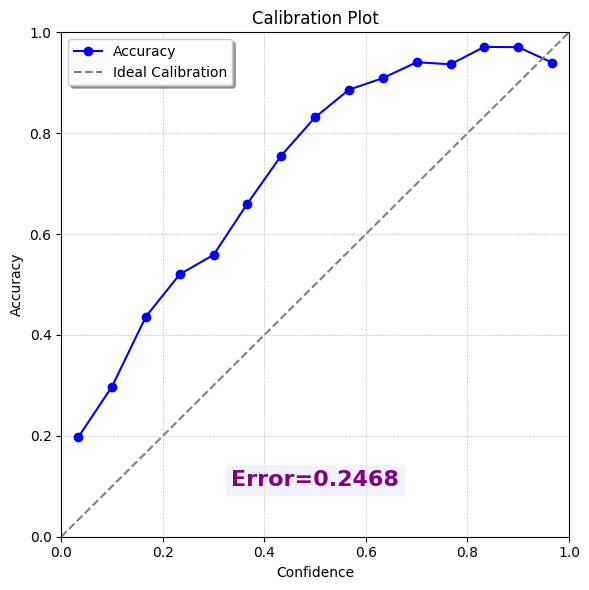

In [ ]:
plot_calibration(df_sgn, error=metrics_sgn['ece'])

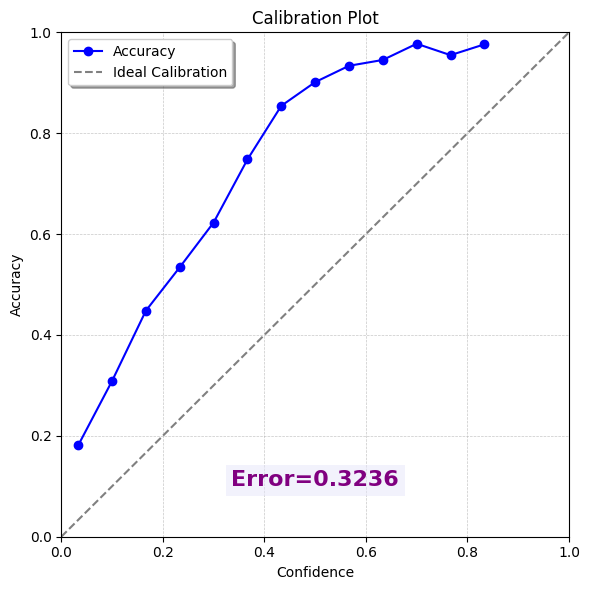

In [ ]:
plot_calibration(df_sgn_mc, error=metrics_sgn_mc['ece'])

In [ ]:
import tensorflow as tf

# CLR inverse function
def clr_inv(p):
    z = tf.math.log(p)
    return z - tf.reduce_mean(z, axis=1, keepdims=True)

# CLR forward function
def clr_forward(z, axis=1):
    return tf.nn.softmax(z, axis=axis)

def helmert_tf(n):
  tensor = tf.ones((n, n))
  H = tf.linalg.set_diag(tf.linalg.band_part(tensor, -1, 0), 1-tf.range(1, n+1, dtype=tf.float32))
  d = tf.range(0, n, dtype=tf.float32) * tf.range(1, n+1, dtype=tf.float32)
  H_full = H / tf.math.sqrt(d)[:, tf.newaxis]
  return H_full[1:]


def ilr_forward(z, axis=-1):
    H = helmert_tf(tf.shape(z)[-1] + 1)
    return clr_forward(z @ H, axis=axis)


def ilr_inv(p):
    z = clr_inv(p)
    H = helmert_tf(tf.shape(p)[-1])
    return z @ tf.linalg.matrix_transpose(H)

# Test the CLR functions
test_input = tf.constant([[0.2, 0.3, 0.5], [0.1, 0.1, 0.8]], dtype=tf.float32)

# Apply forward and inverse transformations
gaussian_result = ilr_inv(test_input)
backtr_result = ilr_forward(gaussian_result)

print("gaussian_result:", gaussian_result.numpy())
print("backtr_result:", backtr_result.numpy())

gaussian_result: [[-2.8670713e-01 -5.8261782e-01]
 [ 1.1100184e-08 -1.6978569e+00]]
backtr_result: [[0.2 0.3 0.5]
 [0.1 0.1 0.8]]
